<a href="https://colab.research.google.com/github/hila-chefer/Transformer-MM-Explainability/blob/main/CLIP_explainability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CLIP Explainability**

In [1]:
!git clone https://github.com/hila-chefer/Transformer-MM-Explainability

import os
os.chdir(f'./Transformer-MM-Explainability')

!pip install einops
!pip install ftfy
!pip install captum

fatal: destination path 'Transformer-MM-Explainability' already exists and is not an empty directory.


# **CLIP**

In [2]:
import torch
import CLIP.clip as clip
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
from captum.attr import visualization

In [3]:
#@title Control context expansion (number of attention layers to consider)
#@title Number of layers for image Transformer
start_layer =  10#@param {type:"number"}

#@title Number of layers for text Transformer
start_layer_text =  0#@param {type:"number"}

In [4]:
def interpret(image, texts, model, device):
    batch_size = texts.shape[0]
    images = image.repeat(batch_size, 1, 1, 1)
    logits_per_image, logits_per_text = model(images, texts)
    probs = logits_per_image.softmax(dim=-1).detach().cpu().numpy()
    index = [i for i in range(batch_size)]
    one_hot = np.zeros((logits_per_image.shape[0], logits_per_image.shape[1]), dtype=np.float32)
    one_hot[torch.arange(logits_per_image.shape[0]), index] = 1
    one_hot = torch.from_numpy(one_hot).requires_grad_(True)
    one_hot = torch.sum(one_hot.cuda() * logits_per_image)
    model.zero_grad()

    image_attn_blocks = list(dict(model.visual.transformer.resblocks.named_children()).values())
    num_tokens = image_attn_blocks[0].attn_probs.shape[-1]
    R = torch.eye(num_tokens, num_tokens, dtype=image_attn_blocks[0].attn_probs.dtype).to(device)
    R = R.unsqueeze(0).expand(batch_size, num_tokens, num_tokens)
    for i, blk in enumerate(image_attn_blocks):
        if i <=start_layer:
          continue
        grad = torch.autograd.grad(one_hot, [blk.attn_probs], retain_graph=True)[0].detach()
        cam = blk.attn_probs.detach()
        cam = cam.reshape(-1, cam.shape[-1], cam.shape[-1])
        grad = grad.reshape(-1, grad.shape[-1], grad.shape[-1])
        cam = grad * cam
        cam = cam.reshape(batch_size, -1, cam.shape[-1], cam.shape[-1])
        cam = cam.clamp(min=0).mean(dim=1)
        R = R + torch.bmm(cam, R)
    image_relevance = R[:, 0, 1:]

    
    text_attn_blocks = list(dict(model.transformer.resblocks.named_children()).values())
    num_tokens = text_attn_blocks[0].attn_probs.shape[-1]
    R_text = torch.eye(num_tokens, num_tokens, dtype=text_attn_blocks[0].attn_probs.dtype).to(device)
    R_text = R_text.unsqueeze(0).expand(batch_size, num_tokens, num_tokens)
    text_attn_blocks = [text_attn_blocks[-1]]
    for i, blk in enumerate(text_attn_blocks):
        if i < start_layer_text:
          continue
        grad = torch.autograd.grad(one_hot, [blk.attn_probs], retain_graph=True)[0].detach()
        cam = blk.attn_probs.detach()
        cam = cam.reshape(-1, cam.shape[-1], cam.shape[-1])
        grad = grad.reshape(-1, grad.shape[-1], grad.shape[-1])
        cam = grad * cam
        cam = cam.reshape(batch_size, -1, cam.shape[-1], cam.shape[-1])
        cam = cam.clamp(min=0).mean(dim=1)
        R_text = R_text + torch.bmm(cam, R_text)
    text_relevance = R_text
   
    return text_relevance, image_relevance

In [5]:
def show_image_relevance(image_relevance, image):
    # create heatmap from mask on image
    def show_cam_on_image(img, mask):
        heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
        heatmap = np.float32(heatmap) / 255
        cam = heatmap + np.float32(img)
        cam = cam / np.max(cam)
        return cam

    image_relevance = image_relevance.reshape(1, 1, 7, 7)
    image_relevance = torch.nn.functional.interpolate(image_relevance, size=224, mode='bilinear')
    image_relevance = image_relevance.reshape(224, 224).cuda().data.cpu().numpy()
    image_relevance = (image_relevance - image_relevance.min()) / (image_relevance.max() - image_relevance.min())
    image = image[0].permute(1, 2, 0).data.cpu().numpy()
    image = (image - image.min()) / (image.max() - image.min())
    vis = show_cam_on_image(image, image_relevance)
    vis = np.uint8(255 * vis)
    vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)
    plt.imshow(vis)

In [6]:
from CLIP.clip.simple_tokenizer import SimpleTokenizer as _Tokenizer
_tokenizer = _Tokenizer()

def show_heatmap_on_text(text, text_encoding, R_text):
  CLS_idx = text_encoding.argmax(dim=-1)
  R_text = R_text[CLS_idx, 1:CLS_idx]
  text_scores = R_text / R_text.sum()
  text_scores = text_scores.flatten()
  print(text_scores)
  text_tokens=_tokenizer.encode(text)
  text_tokens_decoded=[_tokenizer.decode([a]) for a in text_tokens]
  vis_data_records = [visualization.VisualizationDataRecord(text_scores,0,0,0,0,0,text_tokens_decoded,1)]
  visualization.visualize_text(vis_data_records)

In [7]:
clip.clip._MODELS = {
    "ViT-B/32": "https://openaipublic.azureedge.net/clip/models/40d365715913c9da98579312b702a82c18be219cc2a73407c4526f58eba950af/ViT-B-32.pt",
    "ViT-B/16": "https://openaipublic.azureedge.net/clip/models/5806e77cd80f8b59890b7e101eabd078d9fb84e6937f9e85e4ecb61988df416f/ViT-B-16.pt",
}

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device, jit=False)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


In [9]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

tensor([0.0274, 0.0644, 0.0048, 0.1694, 0.7339], device='cuda:0',
       dtype=torch.float16)


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,a man with eye glasses


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


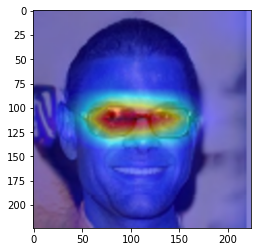

In [10]:
img = preprocess(Image.open("CLIP/glasses.png")).unsqueeze(0).to(device)
texts = ["a man with eyeglasses"]
text = clip.tokenize(texts).to(device)

R_text, R_image = interpret(model=model, image=img, texts=text, device=device)
batch_size = text.shape[0]
for i in range(batch_size):
  show_heatmap_on_text(texts[i], text[i], R_text[i])
  show_image_relevance(R_image[i], img)
  plt.show()

tensor([0.0028, 0.0356, 0.0327, 0.9287], device='cuda:0', dtype=torch.float16)


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,a man with lipstick


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


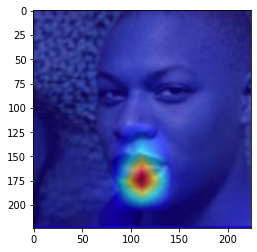

In [11]:
img = preprocess(Image.open("CLIP/lipstick.png")).unsqueeze(0).to(device)
texts = ["a man with lipstick"]
text = clip.tokenize(texts).to(device)

R_text, R_image = interpret(model=model, image=img, texts=text, device=device)
batch_size = text.shape[0]
for i in range(batch_size):
  show_heatmap_on_text(texts[i], text[i], R_text[i])
  show_image_relevance(R_image[i], img)
  plt.show()

tensor([0.0081, 0.0203, 0.1858, 0.0999, 0.0070, 0.0970, 0.5820],
       device='cuda:0', dtype=torch.float16)


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,a rocket standing on a launch pad


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


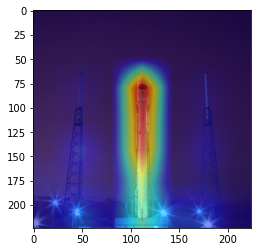

In [12]:
img = preprocess(Image.open("CLIP/rocket.jpg")).unsqueeze(0).to(device)
texts = ["a rocket standing on a launchpad"]
text = clip.tokenize(texts).to(device)

R_text, R_image = interpret(model=model, image=img, texts=text, device=device)
batch_size = text.shape[0]
for i in range(batch_size):
  show_heatmap_on_text(texts[i], text[i], R_text[i])
  show_image_relevance(R_image[i], img)
  plt.show()

tensor([0.0204, 0.9800], device='cuda:0', dtype=torch.float16)


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,a zebra


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


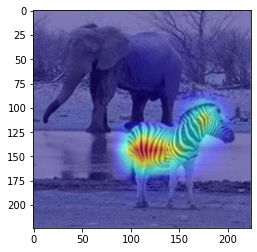

tensor([0.0354, 0.9644], device='cuda:0', dtype=torch.float16)


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,an elephant


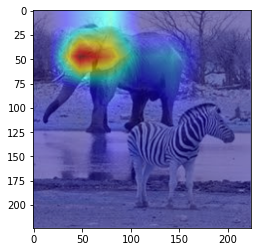

tensor([0.5381, 0.4624], device='cuda:0', dtype=torch.float16)


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,a lake


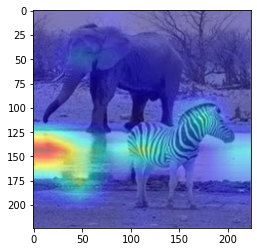

In [13]:
img = preprocess(Image.open("CLIP/el2.png")).unsqueeze(0).to(device)
texts = ['a zebra', 'an elephant', 'a lake']
text = clip.tokenize(texts).to(device)

R_text, R_image = interpret(model=model, image=img, texts=text, device=device)
batch_size = text.shape[0]
for i in range(batch_size):
  show_heatmap_on_text(texts[i], text[i], R_text[i])
  show_image_relevance(R_image[i], img)
  plt.show()

tensor([0.1208, 0.8789], device='cuda:0', dtype=torch.float16)


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,a zebra


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


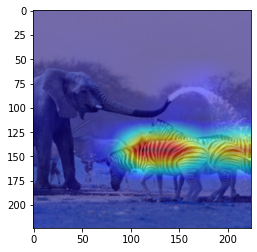

tensor([0.0840, 0.9160], device='cuda:0', dtype=torch.float16)


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,an elephant


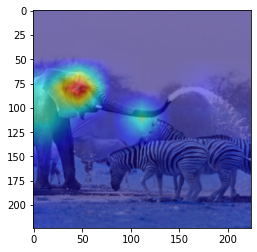

tensor([1.], device='cuda:0', dtype=torch.float16)


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,water


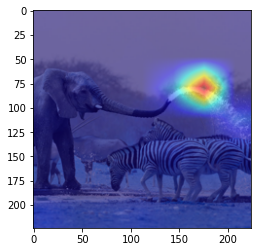

In [14]:
img = preprocess(Image.open("CLIP/el3.png")).unsqueeze(0).to(device)
texts = ['a zebra', 'an elephant', 'water']
text = clip.tokenize(texts).to(device)

R_text, R_image = interpret(model=model, image=img, texts=text, device=device)
batch_size = text.shape[0]
for i in range(batch_size):
  show_heatmap_on_text(texts[i], text[i], R_text[i])
  show_image_relevance(R_image[i], img)
  plt.show()

tensor([0.0370, 0.9629], device='cuda:0', dtype=torch.float16)


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,an elephant


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


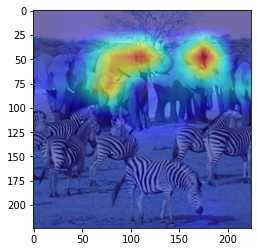

tensor([0.0189, 0.9810], device='cuda:0', dtype=torch.float16)


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,a zebra


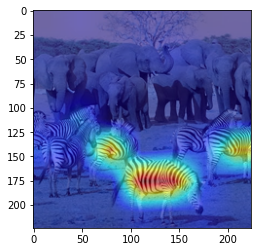

In [15]:
img = preprocess(Image.open("CLIP/el4.png")).unsqueeze(0).to(device)
texts = ['an elephant', 'a zebra']
text = clip.tokenize(texts).to(device)

R_text, R_image = interpret(model=model, image=img, texts=text, device=device)
batch_size = text.shape[0]
for i in range(batch_size):
  show_heatmap_on_text(texts[i], text[i], R_text[i])
  show_image_relevance(R_image[i], img)
  plt.show()

tensor([0.0446, 0.9556], device='cuda:0', dtype=torch.float16)


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,an elephant


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


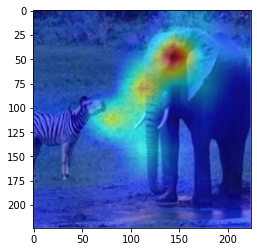

tensor([0.0587, 0.9414], device='cuda:0', dtype=torch.float16)


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,a zebra


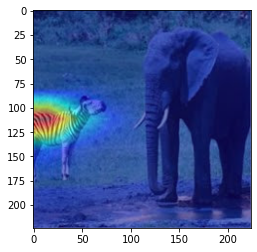

In [16]:
img = preprocess(Image.open("CLIP/el1.png")).unsqueeze(0).to(device)
texts = ['an elephant', 'a zebra']
text = clip.tokenize(texts).to(device)

R_text, R_image = interpret(model=model, image=img, texts=text, device=device)
batch_size = text.shape[0]
for i in range(batch_size):
  show_heatmap_on_text(texts[i], text[i], R_text[i])
  show_image_relevance(R_image[i], img)
  plt.show()

tensor([0.0455, 0.9541], device='cuda:0', dtype=torch.float16)


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,a dog


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


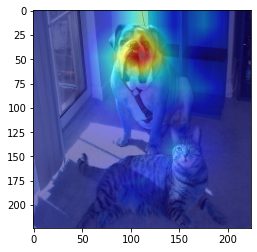

tensor([0.0355, 0.9644], device='cuda:0', dtype=torch.float16)


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,a cat


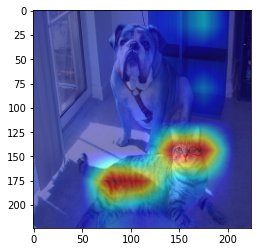

In [17]:
img = preprocess(Image.open("CLIP/catdog.png")).unsqueeze(0).to(device)
texts = ["a dog", "a cat"]
text = clip.tokenize(texts).to(device)

R_text, R_image = interpret(model=model, image=img, texts=text, device=device)
batch_size = text.shape[0]
for i in range(batch_size):
  show_heatmap_on_text(texts[i], text[i], R_text[i])
  show_image_relevance(R_image[i], img)
  plt.show()

tensor([0.0236, 0.9766], device='cuda:0', dtype=torch.float16)


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,a labrador


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


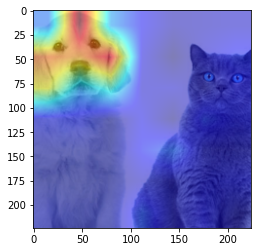

tensor([0.0453, 0.5811, 0.3738], device='cuda:0', dtype=torch.float16)


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,a tabby cat


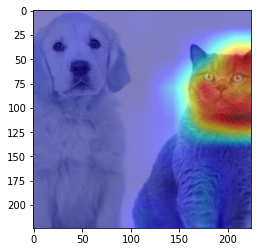

In [18]:
img = preprocess(Image.open("CLIP/dogcat2.png")).unsqueeze(0).to(device)
texts = ["a labrador", "a tabby cat"]
text = clip.tokenize(texts).to(device)

R_text, R_image = interpret(model=model, image=img, texts=text, device=device)
batch_size = text.shape[0]
for i in range(batch_size):
  show_heatmap_on_text(texts[i], text[i], R_text[i])
  show_image_relevance(R_image[i], img)
  plt.show()

tensor([0.1227, 0.8770], device='cuda:0', dtype=torch.float16)


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,a parrot


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


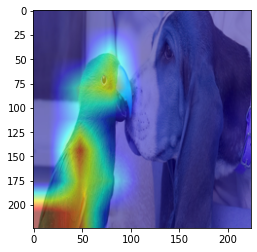

tensor([0.2559, 0.7441], device='cuda:0', dtype=torch.float16)


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,a dog


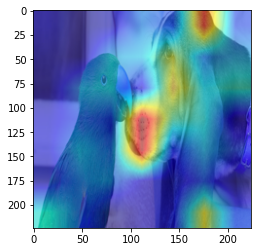

In [19]:
img = preprocess(Image.open("CLIP/dogbird.png")).unsqueeze(0).to(device)
texts = ["a parrot", "a dog"]
text = clip.tokenize(texts).to(device)

R_text, R_image = interpret(model=model, image=img, texts=text, device=device)
batch_size = text.shape[0]
for i in range(batch_size):
  show_heatmap_on_text(texts[i], text[i], R_text[i])
  show_image_relevance(R_image[i], img)
  plt.show()

tensor([0.0723, 0.1295, 0.0591, 0.0403, 0.6987], device='cuda:0',
       dtype=torch.float16)


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,a portrait of an astronaut


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


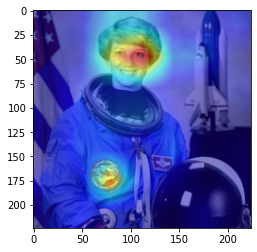

tensor([0.5264, 0.4736], device='cuda:0', dtype=torch.float16)


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,a rocket


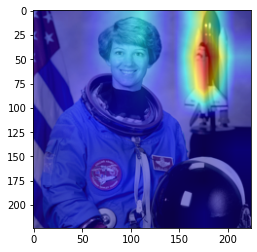

tensor([0.2212, 0.6348, 0.1438], device='cuda:0', dtype=torch.float16)


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,an astronaut suit


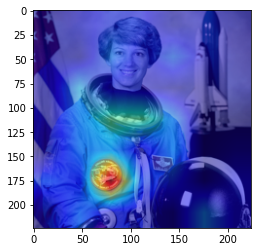

In [20]:
img = preprocess(Image.open("CLIP/astronaut.png")).unsqueeze(0).to(device)
texts = ["a portrait of an astronaut", "a rocket", "an astronaut suit"]
text = clip.tokenize(texts).to(device)

R_text, R_image = interpret(model=model, image=img, texts=text, device=device)
batch_size = text.shape[0]
for i in range(batch_size):
  show_heatmap_on_text(texts[i], text[i], R_text[i])
  show_image_relevance(R_image[i], img)
  plt.show()